<a href="https://colab.research.google.com/github/arpan031/Stock_Market_Analysis/blob/main/Stock_Market_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --quiet yfinance pandas numpy matplotlib scikit-learn statsmodels plotly

In [19]:
# Clean up any previous installations that might be corrupted
!pip uninstall -y prophet pystan cmdstanpy
# Install cmdstanpy first for a stable Stan backend
!pip install --quiet cmdstanpy
# Then install prophet, which should now use cmdstanpy
!pip install --quiet prophet

Found existing installation: prophet 1.1.7
Uninstalling prophet-1.1.7:
  Successfully uninstalled prophet-1.1.7
Found existing installation: cmdstanpy 1.3.0
Uninstalling cmdstanpy-1.3.0:
  Successfully uninstalled cmdstanpy-1.3.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 149.8 MB/s eta 0:00:00


In [15]:
# LSTM / DL
!pip install --quiet tensorflow

In [13]:
# Streamlit UI + Cloudflared tunnel (no auth token needed)
!pip install --quiet streamlit cloudflared

In [5]:
import os, warnings, math
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report, confusion_matrix

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from prophet import Prophet

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

print("✅ Environment ready")

✅ Environment ready


In [6]:
#Utility helpers

def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(np.asarray(y_true), np.asarray(y_pred))))

def train_test_split_series(series, test_ratio=0.2):
    n = len(series)
    cut = int(n * (1 - test_ratio))
    return series[:cut], series[cut:]

def plot_pred(actual_index, actual, pred, title):
    plt.figure(figsize=(12,5))
    plt.plot(actual_index, actual, label="Actual")
    plt.plot(actual_index, pred, label="Prediction")
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Close")
    plt.legend()
    plt.show()


In [7]:
#Load data
TICKER = "AAPL"
START  = "2015-01-01"
END    = "2024-12-31"

df = yf.download(TICKER, start=START, end=END)
df = df.dropna()
assert "Close" in df.columns and len(df) > 400, "Not enough data downloaded."
print(f"✅ Data loaded: {TICKER}, rows={len(df)} (from {df.index.min().date()} to {df.index.max().date()})")


[*********************100%***********************]  1 of 1 completed

✅ Data loaded: AAPL, rows=2515 (from 2015-01-02 to 2024-12-30)


In [8]:
#KNN (Up/Down movement classification)

df_knn = df.copy()
df_knn["Return"] = df_knn["Close"].pct_change()
df_knn["Target"] = (df_knn["Return"] > 0).astype(int)
df_knn = df_knn.dropna()
X = df_knn[["Open","High","Low","Close","Volume"]].values
y = df_knn["Target"].values

X_train, X_test, y_train_cls, y_test_cls = train_test_split(X, y, test_size=0.2, shuffle=False)

from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train_cls)
y_pred_cls = knn.predict(X_test)

knn_acc = accuracy_score(y_test_cls, y_pred_cls)
print(f"✅ KNN Accuracy: {knn_acc:.4f}")
print(confusion_matrix(y_test_cls, y_pred_cls))
print(classification_report(y_test_cls, y_pred_cls, zero_division=0))

✅ KNN Accuracy: 0.5427
[[ 70 149]
 [ 81 203]]
              precision    recall  f1-score   support

           0       0.46      0.32      0.38       219
           1       0.58      0.71      0.64       284

    accuracy                           0.54       503
   macro avg       0.52      0.52      0.51       503
weighted avg       0.53      0.54      0.53       503



/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


✅ ARIMA(5, 1, 0) RMSE: 69.4705


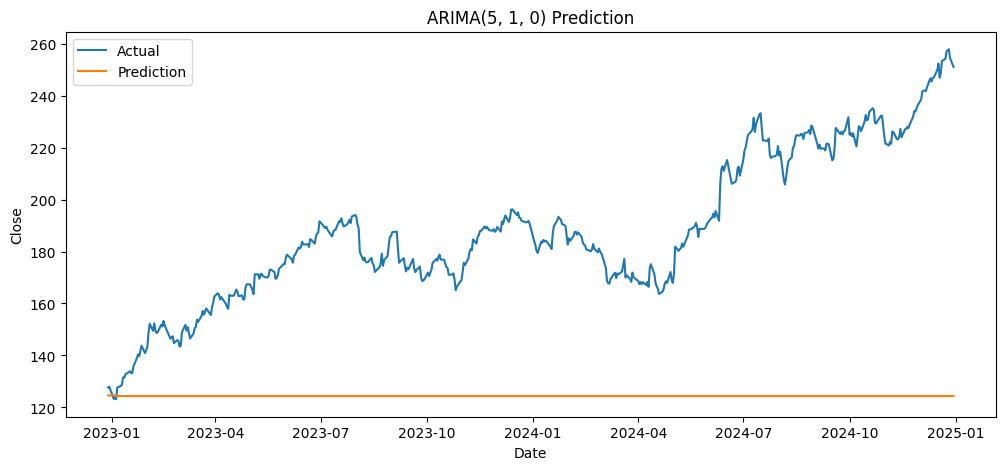

In [9]:
#ARIMA (non-seasonal)

series = df["Close"].astype(float)
train_arima, test_arima = train_test_split_series(series, test_ratio=0.2)

# simple baseline order; adjust if needed
arima_order = (5,1,0)
arima_model = ARIMA(train_arima, order=arima_order)
arima_fit = arima_model.fit()
arima_forecast = arima_fit.forecast(steps=len(test_arima))

arima_rmse = rmse(test_arima.values, arima_forecast.values)
print(f"✅ ARIMA{arima_order} RMSE: {arima_rmse:.4f}")
plot_pred(test_arima.index, test_arima.values, arima_forecast.values, f"ARIMA{arima_order} Prediction")


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


✅ SARIMA(1, 1, 1)x(1, 1, 1, 5) RMSE: 55.5600


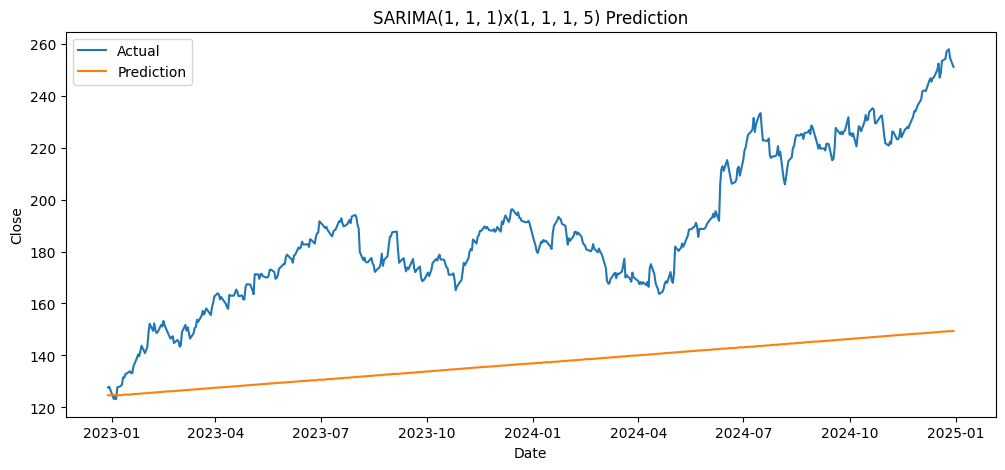

In [10]:
 #SARIMA (weekly seasonality on daily data -> 5)

 # For stocks, seasonality is weak, but we include SARIMA by request
# seasonal_order = (P,D,Q,m); m=5 ~ weekly trading cadence
sarima_order = (1,1,1)
sarima_seasonal_order = (1,1,1,5)
sarima_model = SARIMAX(train_arima, order=sarima_order, seasonal_order=sarima_seasonal_order,
                       enforce_stationarity=False, enforce_invertibility=False)
sarima_fit = sarima_model.fit(disp=False)
sarima_forecast = sarima_fit.forecast(steps=len(test_arima))

sarima_rmse = rmse(test_arima.values, sarima_forecast.values)
print(f"✅ SARIMA{sarima_order}x{sarima_seasonal_order} RMSE: {sarima_rmse:.4f}")
plot_pred(test_arima.index, test_arima.values, sarima_forecast.values,
          f"SARIMA{sarima_order}x{sarima_seasonal_order} Prediction")

✅ Prophet RMSE: 19.0681


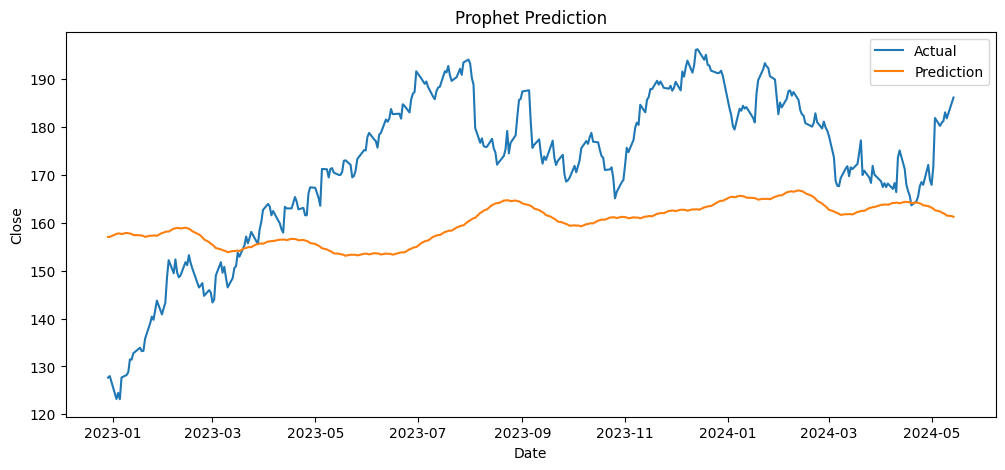

In [20]:
#Prophet

df_prophet = df[["Close"]].copy().reset_index()
df_prophet.columns = ["ds","y"]

cut = int(len(df_prophet)*0.8)
train_prophet = df_prophet.iloc[:cut].copy()
test_prophet  = df_prophet.iloc[cut:].copy()

m = Prophet(daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=True)
m.fit(train_prophet)

future = m.make_future_dataframe(periods=len(test_prophet), freq="D")
fcst = m.predict(future)

# Align with test range
fcst_test = pd.merge(test_prophet, fcst[["ds", "yhat"]], on="ds", how="left")
fcst_test = fcst_test.dropna(subset=["yhat"])
prophet_rmse = rmse(fcst_test["y"].values, fcst_test["yhat"].values)
print(f"✅ Prophet RMSE: {prophet_rmse:.4f}")

# Plot Prophet results (matplotlib)
plot_pred(fcst_test["ds"].values, fcst_test["y"].values, fcst_test["yhat"].values, "Prophet Prediction")

Epoch 1/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0239
Epoch 2/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 9.7760e-04
Epoch 3/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 8.0043e-04
Epoch 4/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 8.3015e-04
Epoch 5/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 6.4889e-04
Epoch 6/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.3619e-04
Epoch 7/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 7.1012e-04
Epoch 8/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 5.1805e-04
Epoch 9/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 5.7973e-04
Epoch 10/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 5.2379e-04
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
✅ LSTM RMSE: 11.8044


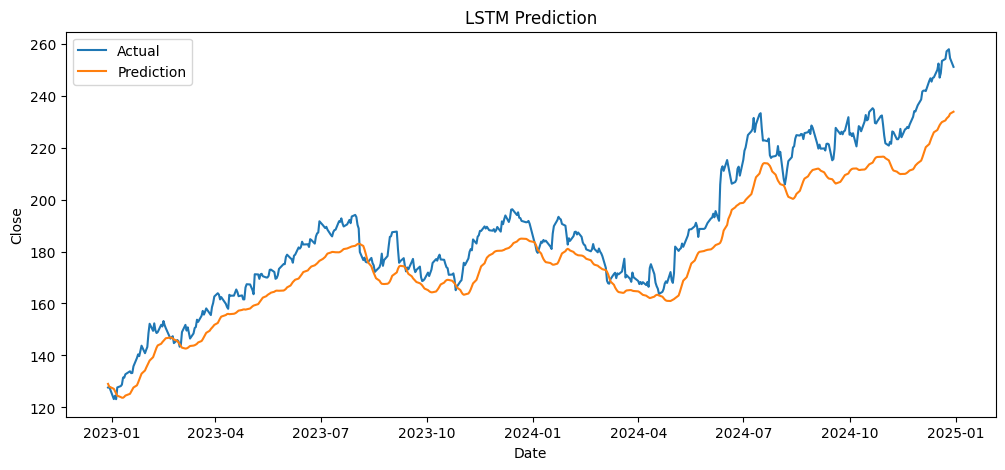

In [21]:
# LSTM

close_vals = df[["Close"]].values.astype(float)
scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(close_vals)

lookback = 60
train_size = int(len(scaled)*0.8)
train_lstm = scaled[:train_size]
test_lstm  = scaled[train_size - lookback:]

def make_sequences(data, lb):
    Xs, ys = [], []
    for i in range(lb, len(data)):
        Xs.append(data[i-lb:i, 0])
        ys.append(data[i, 0])
    return np.array(Xs), np.array(ys)

X_train_lstm, y_train_lstm = make_sequences(train_lstm, lookback)
X_test_lstm,  y_test_lstm  = make_sequences(test_lstm,  lookback)

X_train_lstm = X_train_lstm.reshape((X_train_lstm.shape[0], X_train_lstm.shape[1], 1))
X_test_lstm  = X_test_lstm.reshape((X_test_lstm.shape[0],  X_test_lstm.shape[1],  1))

tf.keras.backend.clear_session()
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(lookback,1)),
    Dropout(0.2),
    LSTM(64, return_sequences=False),
    Dropout(0.2),
    Dense(32),
    Dense(1)
])
model.compile(optimizer="adam", loss="mse")
history = model.fit(X_train_lstm, y_train_lstm, epochs=10, batch_size=32, verbose=1)

pred_lstm_scaled = model.predict(X_test_lstm)
pred_lstm = scaler.inverse_transform(pred_lstm_scaled)
y_test_lstm_inv = scaler.inverse_transform(y_test_lstm.reshape(-1,1))

# Build index for test (align to last segment)
test_index = df.index[train_size:]

lstm_rmse = rmse(y_test_lstm_inv.flatten(), pred_lstm.flatten())
print(f"✅ LSTM RMSE: {lstm_rmse:.4f}")
plot_pred(test_index, y_test_lstm_inv.flatten(), pred_lstm.flatten(), "LSTM Prediction")


In [22]:
#Scoreboard
results = pd.DataFrame({
    "Model": ["ARIMA(5,1,0)", "SARIMA(1,1,1)x(1,1,1,5)", "Prophet", "LSTM (lookback=60)"],
    "RMSE":  [arima_rmse, sarima_rmse, prophet_rmse, lstm_rmse]
}).sort_values("RMSE")
print("🏁 RMSE leaderboard (lower is better)")
print(results.to_string(index=False))

🏁 RMSE leaderboard (lower is better)
                  Model      RMSE
     LSTM (lookback=60) 11.804449
                Prophet 19.068126
SARIMA(1,1,1)x(1,1,1,5) 55.560021
           ARIMA(5,1,0) 69.470514


In [23]:
%%writefile app_ui.py
import streamlit as st
import yfinance as yf
import numpy as np
import pandas as pd
from prophet import Prophet
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import warnings
warnings.filterwarnings("ignore")

# =========================
# PAGE CONFIG
# =========================
st.set_page_config(page_title="📈 Stock Forecasting Suite", layout="wide")
st.title("📈 Stock Forecasting (ARIMA | SARIMA | Prophet | LSTM)")
st.caption("Compare multiple time-series forecasting models in one place 🚀")

# =========================
# SIDEBAR INPUTS
# =========================
with st.sidebar:
    st.header("⚙️ Settings")
    ticker = st.text_input("Enter Stock Ticker", "AAPL")
    start = st.date_input("Start Date", pd.to_datetime("2018-01-01"))
    end   = st.date_input("End Date",   pd.to_datetime("today"))
    horizon = st.slider("Forecast Horizon (days)", 5, 60, 20)
    run = st.button("Run Models")

# =========================
# MAIN APP
# =========================
if run:
    st.info("⏳ Downloading stock data...")
    df = yf.download(ticker, start=start, end=end).dropna()

    if df.empty:
        st.error("No data returned. Check ticker/dates.")
        st.stop()

    # -------------------------
    # 📌 Raw Close Price with Moving Averages
    # -------------------------
    series = df["Close"].astype(float)
    chart = pd.DataFrame({
        "Close": series.values.ravel(),
        "MA_20": series.rolling(window=20).mean().values.ravel(),
        "MA_50": series.rolling(window=50).mean().values.ravel()
    }, index=series.index)

    st.subheader("📌 Raw Close Price with Moving Averages")
    st.line_chart(chart)

    # -------------------------
    # 📉 Daily Returns
    # -------------------------
    st.subheader("📉 Daily Returns Distribution")
    returns = df["Close"].pct_change().dropna()
    st.bar_chart(returns)

    # -------------------------
    # Train/Test Split
    # -------------------------
    cut = int(len(series) * 0.8)
    train, test = series[:cut], series[cut:]

    # -------------------------
    # 🤖 MODELS
    # -------------------------
    st.subheader("🤖 Running Models...")
    st.info("⏳ This may take a few minutes...")
    results = {}

    # ===== ARIMA =====
    with st.spinner("Training ARIMA..."):
        try:
            arima = ARIMA(train, order=(5,1,0)).fit()
            arima_fc = arima.forecast(steps=len(test))
            rmse = np.sqrt(((test.values - arima_fc.values)**2).mean())
            results["ARIMA(5,1,0)"] = (rmse, arima_fc)
        except Exception as e:
            st.warning(f"ARIMA failed: {e}")
            results["ARIMA(5,1,0)"] = (np.nan, pd.Series(index=test.index))

    # ===== SARIMA =====
    with st.spinner("Training SARIMA..."):
        try:
            sarima = SARIMAX(
                train, order=(1,1,1), seasonal_order=(1,1,1,5),
                enforce_stationarity=False, enforce_invertibility=False
            ).fit(disp=False)
            sarima_fc = sarima.forecast(steps=len(test))
            rmse = np.sqrt(((test.values - sarima_fc.values)**2).mean())
            results["SARIMA(1,1,1)x(1,1,1,5)"] = (rmse, sarima_fc)
        except Exception as e:
            st.warning(f"SARIMA failed: {e}")
            results["SARIMA"] = (np.nan, pd.Series(index=test.index))

    # ===== PROPHET =====
    with st.spinner("Training Prophet..."):
        try:
            # Prepare training data (force 1D y)
            prophet_df = pd.DataFrame({
                "ds": train.index,
                "y": train.values.ravel()   # ensure 1D
            })

            model = Prophet(daily_seasonality=True)
            model.fit(prophet_df)

            # Forecast on test set
            future = pd.DataFrame({"ds": test.index})
            forecast = model.predict(future)
            prophet_fc = forecast["yhat"]

            # Compute RMSE
            rmse = np.sqrt(((test.values - prophet_fc.values) ** 2).mean())

            # Save result
            results["Prophet 🔮"] = (rmse, pd.Series(prophet_fc.values, index=test.index))
        except Exception as e:
            st.warning(f"Prophet failed: {e}")
            results["Prophet 🔮"] = (np.nan, pd.Series(index=test.index))

    # ===== LSTM =====
    with st.spinner("Training LSTM... (1-2 mins)"):
        try:
            vals = df[["Close"]].values.astype(float)
            scaler = MinMaxScaler((0,1))
            scaled = scaler.fit_transform(vals)
            lb = 60
            tr = int(len(scaled) * 0.8)

            # Training sequences
            trX, trY = [], []
            for i in range(lb, tr):
                trX.append(scaled[i-lb:i,0])
                trY.append(scaled[i,0])
            trX, trY = np.array(trX), np.array(trY)
            trX = trX.reshape((trX.shape[0], trX.shape[1], 1))

            model = Sequential([
                LSTM(64, return_sequences=True, input_shape=(lb,1)),
                Dropout(0.2),
                LSTM(64, return_sequences=False),
                Dropout(0.2),
                Dense(32),
                Dense(1)
            ])
            model.compile(optimizer="adam", loss="mse")
            model.fit(trX, trY, epochs=6, batch_size=32, verbose=0)

            # Testing sequences
            tst = scaled[tr-lb:]
            tsX, tsY = [], []
            for i in range(lb, len(tst)):
                tsX.append(tst[i-lb:i,0])
                tsY.append(tst[i,0])
            tsX, tsY = np.array(tsX), np.array(tsY)
            tsX = tsX.reshape((tsX.shape[0], tsX.shape[1], 1))

            pred = model.predict(tsX, verbose=0)
            pred_inv = scaler.inverse_transform(pred).flatten()
            tsY_inv = scaler.inverse_transform(tsY.reshape(-1,1)).flatten()
            rmse = np.sqrt(((tsY_inv - pred_inv)**2).mean())
            results["LSTM 🧠"] = (rmse, pd.Series(pred_inv, index=df.index[tr:]))
        except Exception as e:
            st.warning(f"LSTM failed: {e}")
            results["LSTM 🧠"] = (np.nan, pd.Series(index=df.index[cut:]))

    # -------------------------
    # 🏆 Model Leaderboard
    # -------------------------
    st.header("🏆 Model Leaderboard")
    board = pd.DataFrame({
        "Model": list(results.keys()),
        "RMSE": [results[m][0] for m in results]
    }).sort_values("RMSE")
    st.dataframe(board, hide_index=True)

    cols = st.columns(len(results))
    for i,(m,(rmse,_)) in enumerate(results.items()):
        cols[i].metric(label=m, value=f"{rmse:.2f}" if not np.isnan(rmse) else "N/A")

    # -------------------------
    # 📈 PREDICTION PLOTS
    # -------------------------
    st.header("📈 Predictions")
    st.subheader("Train Window")
    chart = pd.DataFrame({"Actual": train.values.ravel()}, index=train.index)
    for m,(rmse,fc) in results.items():
        if not np.isnan(rmse):
            fc_aligned = pd.Series(fc.values, index=fc.index)
            chart[m] = fc_aligned.reindex(chart.index)

    st.line_chart(chart)

    st.subheader("Test Window")
    chart = pd.DataFrame({"Actual": series.iloc[cut:].squeeze()}, index=series.index[cut:])
    for m,(rmse,fc) in results.items():
        if not np.isnan(rmse):
            chart[m] = fc.values
    st.line_chart(chart)

    # -------------------------
    # 🔮 HORIZON FORECAST
    # -------------------------
    st.header("🔮 Horizon Forecast")
    st.subheader(f"{horizon}-Day Forecast (ARIMA baseline)")
    try:
        final_arima = ARIMA(series, order=(5,1,0)).fit()
        future_vals = final_arima.forecast(steps=horizon)
        st.line_chart(future_vals)
        st.download_button("📥 Download Forecast CSV", future_vals.to_csv().encode(), "forecast.csv")
    except Exception as e:
        st.warning(f"ARIMA horizon forecast not available: {e}")


Writing app_ui.py


In [24]:
# Install cloudflared manually
!wget -q https://github.com/cloudflare/cloudflared/releases/latest/download/cloudflared-linux-amd64.deb
!dpkg -i cloudflared-linux-amd64.deb
!rm cloudflared-linux-amd64.deb


Selecting previously unselected package cloudflared.
(Reading database ... 121235 files and directories currently installed.)
Preparing to unpack cloudflared-linux-amd64.deb ...
Unpacking cloudflared (2025.11.1) ...
Setting up cloudflared (2025.11.1) ...
Processing triggers for man-db (2.10.2-1) ...


In [25]:
!pkill -f streamlit
!pkill -f cloudflared



In [26]:
!streamlit run app_ui.py --server.port 8501 &>/content/streamlit.log &


In [27]:
!tail -n 20 /content/streamlit.log





  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://136.110.56.97:8501



In [28]:
!cloudflared tunnel --url http://localhost:8501 --no-autoupdate

2025-11-13T09:24:50Z INF Thank you for trying Cloudflare Tunnel. Doing so, without a Cloudflare account, is a quick way to experiment and try it out. However, be aware that these account-less Tunnels have no uptime guarantee, are subject to the Cloudflare Online Services Terms of Use (https://www.cloudflare.com/website-terms/), and Cloudflare reserves the right to investigate your use of Tunnels for violations of such terms. If you intend to use Tunnels in production you should use a pre-created named tunnel by following: https://developers.cloudflare.com/cloudflare-one/connections/connect-apps
2025-11-13T09:24:50Z INF Requesting new quick Tunnel on trycloudflare.com...
2025-11-13T09:24:55Z INF +--------------------------------------------------------------------------------------------+
2025-11-13T09:24:55Z INF |  Your quick Tunnel has been created! Visit it at (it may take some time to be reachable):  |
2025-11-13T09:24:55Z INF |  https://cooked-promotional-par-limousines.trycloudfla